<a href="https://colab.research.google.com/github/heet9022/Emotion-Detection/blob/master/emo_det_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup fastai with Colab

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
pd.set_option('max_colwidth', 1000)
import numpy as np
import seaborn as sns

#Load Data

In [0]:
base_dir = 'drive/My Drive/Colab_datasets/Emotion_detection/'

In [0]:
PATH = Path(base_dir+'fer2013')
PATH.ls()

[PosixPath('drive/My Drive/Colab_datasets/Emotion_detection/fer2013/fer2013.csv'),
 PosixPath('drive/My Drive/Colab_datasets/Emotion_detection/fer2013/README'),
 PosixPath('drive/My Drive/Colab_datasets/Emotion_detection/fer2013/fer2013.bib')]

In [0]:
df = pd.read_csv(PATH/'fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 154 153 164 173 178 185 185 189 187 186 193 194 185 183 186 180 173 166 161 147 133 172 151 114 161 161 146 131 104 95 132 163 123 119 129 140 120 151 149 149 153 137 115 129 166 170 181 164 143 157 156 169 179 185 183 186 186 184 190 191 184 186 190 183 175 168 160 147 136 135 167 136 108 153 167 149 137 111 90 134 162 121 122 141 137 151 151 156 143 116 124 159 164 174 169 135 144 155 153 164 170 176 178 177 178 187 185 181 182 183 181 178 170 164 158 148 144 130 136 173 130 97 137 167 157 138 113 90 138 168 109 123 146 151 152 155 127 113 159 167 170 171 142 131 140 154 162 168 169 169 164 168 173 176 179 178 176 173 172 170 161 154 152 146 145 137 124 130 171 124 102 133 164 152 138 110 86 154 149 100 139 153 151 136 113 142 159 161 174 150 127 136 140 154 164 163 167 173 172 171 170 167 168 172 167 162 161 160 163 163 154 145 146 140 133 122 135 167 127 101 126 164 147 132 95 91 166 115 113 158 143 121 134 153 153 164 162 131 130 136...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38 39 74 138 161 164 179 190 201 210 216 220 224 222 218 216 213 217 220 220 218 217 212 174 160 162 160 139 135 137 131 94 56 36 44 27 16 229 175 148 173 154 151 171 172 183 101 23 25 67 127 164 170 171 182 199 212 219 220 224 226 226 226 226 226 227 227 228 225 221 217 202 174 158 155 145 126 126 129 99 70 37 27 35 27 214 156 157 168 153 172 168 175 100 16 8 47 117 169 175 175 183 194 204 214 218 223 225 227 228 226 229 231 232 232 229 227 225 224 217 198 174 154 134 110 97 115 96 69 52 28 22 28 202 153 166 156 164 166 170 116 26 2 21 90 165 180 180 181 192 206 210 213 216 220 224 224 226 224 228 227 227 228 231 229 225 228 226 218 196 168 148 111 80 89 97 56 50 38 26 23 190 163 167 156 168 172 136 36 0 24 69 146 180 179 183 196 204 211 214 215 214 217 218 217 220 223 220 220 222 224 227 229 228 228 228 227 216 187 156 125 92 62 83 61 44 46 31 31 181 173 156 167 176 159 61 0 8 62 121 175 185 188 197 210 215 222 225 221 216 214 214 214 2...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 19 43 52 13 26 40 59 65 12 20 63 99 98 98 111 75 62 41 73 118 140 192 186 187 188 190 190 187 182 176 173 172 173 25 34 29 35 29 26 20 23 19 31 22 21 20 31 26 17 34 75 37 18 38 80 85 25 38 26 34 97 94 76 86 95 70 39 98 129 185 188 188 189 190 190 188 182 176 173 172 173 26 29 25 35 25 30 20 21 16 28 34 26 15 17 19 22 29 62 64 47 45 76 76 78 65 82 12 14 56 56 72 74 66 65 86 129 172 190 187 189 190 190 187 182 177 172 172 174 26 33 32 31 25 33 26 21 16 16 37 27 14 15 12 17 31 38 40 58 73 59 35 82 68 72 43 22 33 52 51 66 71 57 71 121 160 191 188 189 190 190 187 184 178 173 173 174 29 40 29 29 32 32 28 26 19 13 23 34 17 18 14 15 26 25 21 40 82 44 29 34 36 32 36 59 55 38 46 64 71 62 60 107 137 191 189 190 190 190 188 184 178 175 173 175 33 39 25 33 37 33 25 30 20 18 18 23 20 22 20 17 33 20 18 25 37 31 22 29 28 24 29 38 67 38 35 75 68 66 58 89 110 179 191 189 189 190 187 184 179 175 

In [0]:
# 7 types (emotions) of images from the Data Description of the Kaggle challenge
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for l in range(len(labels)):
    print(f'{l} = {labels[l]}')

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [0]:
# 3 usages of the images
usages = df['Usage'].unique();usages

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

n_train = len(df_train)
n_valid = len(df_valid)
n_test = len(df_test)
n = len(df)

print(f'{n_train} (Training) + {n_valid} (PublicTest) + {n_test} (PrivateTest) = {n} images')

28709 (Training) + 3589 (PublicTest) + 3589 (PrivateTest) = 35887 images


#View Data

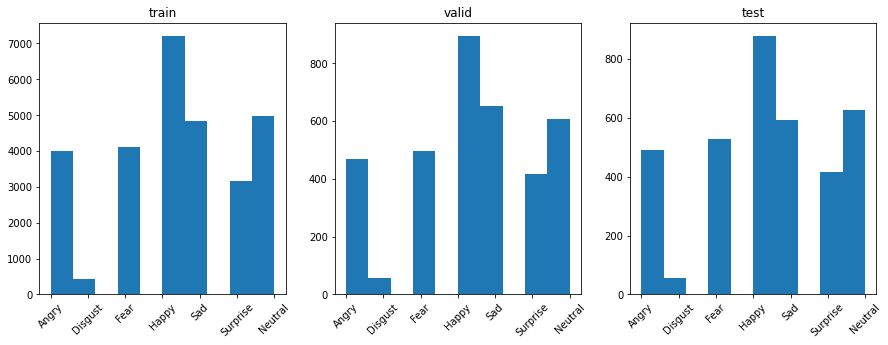

In [0]:
# histograms of train, val and test
def setup_axe(axe,df,title):
    axe.hist(df['emotion'])
    axe.set_xticks(list(range(len(labels))))
    axe.set_xticklabels(labels, rotation=45)
    axe.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(15,5))
setup_axe(axes[0],df_train,'train')
setup_axe(axes[1],df_valid,'valid')
setup_axe(axes[2],df_test,'test')
plt.show()

In [0]:
# (train) pourcentage of images by emotion
ne = df_train['emotion'].value_counts(ascending=True)
for k,v in zip(ne.keys(),ne.values):
    pct = round(v/n*100,2)
    print(f'({pct}%) {v} {labels[k]}')

(1.21%) 436 Disgust
(8.84%) 3171 Surprise
(11.13%) 3995 Angry
(11.42%) 4097 Fear
(13.46%) 4830 Sad
(13.84%) 4965 Neutral
(20.1%) 7215 Happy


Convert Pictures to Images

In [0]:
# get image + emotion from a dataframe row
# image format : numpy array RGB (48,48,3)
def row2image(row):
    pixels, emotion = row['pixels'], row['emotion']
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# display image with title (emotion label)
# image format : numpy array RGB (48,48,3)
def show(img_title):
    plt.imshow(img_title[0])
    plt.title(labels[img_title[1]])

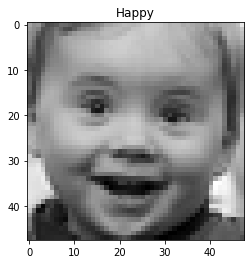

In [0]:
row = df_train.iloc[2222]
img = row2image(row)
show(img)

Create the folders of Data 

In [0]:
# create the folders train, val and test
Path(PATH/'train').mkdir(exist_ok=True)
Path(PATH/'valid').mkdir(exist_ok=True)
Path(PATH/'test').mkdir(exist_ok=True)

In [0]:
PATH_train = PATH/'train'
PATH_valid = PATH/'valid'
PATH_test = PATH/'test'

In [0]:
# create the folders of the 7 emotions in train, val and test folders
for l in labels:
    Path(PATH_train/l).mkdir(exist_ok=True)
    Path(PATH_valid/l).mkdir(exist_ok=True)
    Path(PATH_test/l).mkdir(exist_ok=True)

Save the Images in the folder

In [0]:
from PIL import Image as Img
from PIL import ImageTk

In [0]:
# create images from pixels and save them into their corresponding subfolder of train, val and test
def createImages(df,path):
    for e in range(len(labels)):
        df_e = df[df['emotion'] == e]
        path_e = path/labels[e]
        i=0
        for index, row in df_e.iterrows():
            img = row2image(row)
            image = Img.fromarray(img[0], 'RGB')
            fname = str(e)+'_'+str(i)+'.jpg'
            image.save(path_e/fname)
            i += 1

In [0]:
# %%time
# createImages(df_train,PATH_train)
# createImages(df_valid,PATH_valid)
# createImages(df_test,PATH_test)

CPU times: user 1min 48s, sys: 6.53 s, total: 1min 55s
Wall time: 3min 51s


#Training

In [0]:
# data augmentation
tfms = get_transforms()

In [93]:
# ImageDataBunch
# bs=32, size=299 : ajusted hyper-parameters to resnet50
data = ImageDataBunch.from_folder(PATH, test='test', ds_tfms=tfms, bs=32, size=299).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: drive/My Drive/Colab_datasets/Emotion_detection/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: drive/My Drive/Colab_datasets/Emotion_detection/fer2013;

Test: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: drive/My Drive/Colab_datasets/Emotion_detection/fer2013

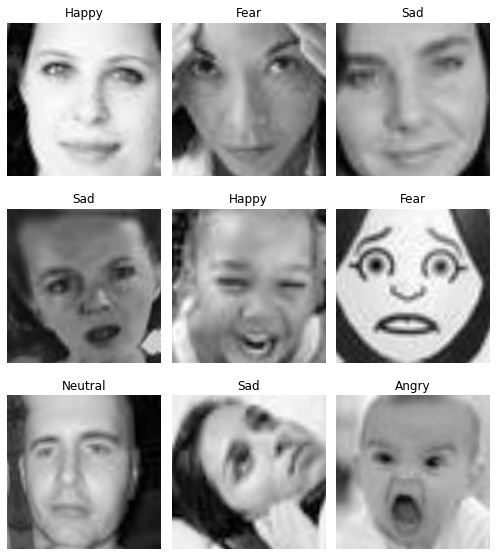

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
 7,
 28709,
 3589)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.674850,1.503736,0.425188,06:36
1,1.358632,1.229160,0.538590,06:31
2,1.211847,1.125948,0.568961,06:31
3,1.155516,1.099276,0.579549,06:30


In [0]:
learn.save('fer2013-stage-1')

In [0]:
learn.load('fer2013-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: drive/My Drive/Colab_datasets/Emotion_detection/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Angry,Angry,Angry,Angry,Angry
Path: drive/My Drive/Colab_datasets/Emotion_detection/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


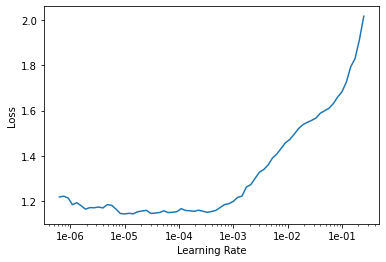

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.107278,1.041229,0.607133,06:57
1,1.027173,1.015656,0.611870,06:52


In [0]:
learn.save('fer2013-stage-2')

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.029001,0.995876,0.621900,06:54
1,0.944757,0.978662,0.628587,07:04


In [0]:
learn.save('fer2013-stage-3')

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.931513,0.972013,0.630538,07:12
1,0.920245,0.950529,0.640290,06:57


In [0]:
learn.save('fer2013-stage-4')

In [0]:
learn.load('fer2013-stage-4')

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.918253,0.955306,0.638339,06:50
1,0.873402,0.941250,0.650599,06:56


In [0]:
learn.save('fer2013-stage-5')

In [0]:
learn.load('fer2013-stage-5')

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.848973,0.945621,0.648370,07:13
1,0.801997,0.933046,0.648649,07:13


In [0]:
learn.save('fer2013-stage-6')

#Results

In [0]:
learn.load('fer2013-stage-5')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

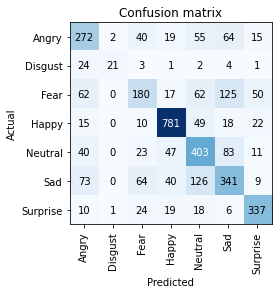

In [0]:
interp.plot_confusion_matrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


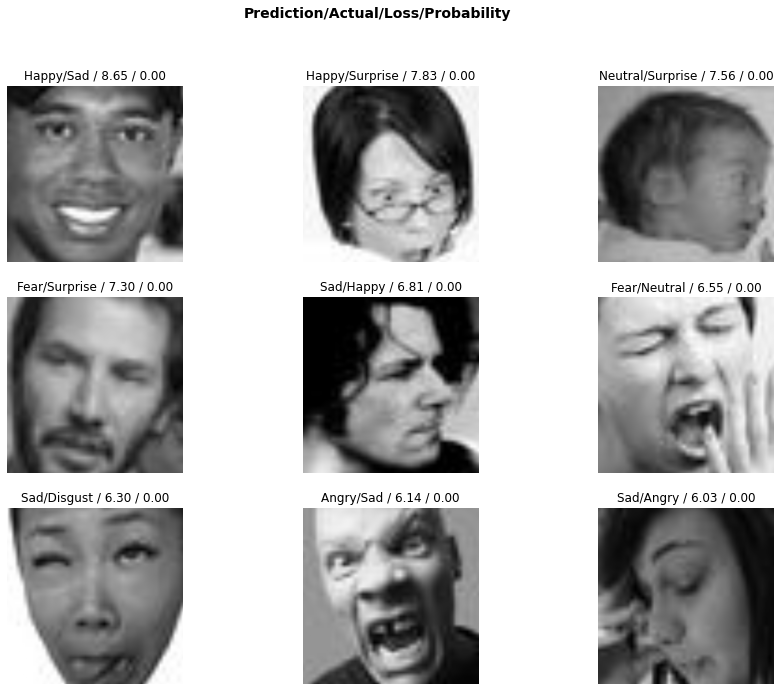

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
val_probs, val_targets = learn.get_preds()

In [0]:
val_preds = torch.argmax(val_probs,1)

In [0]:
val_acc = (val_preds == val_targets).type(torch.FloatTensor).mean().item()
print(f'valid accuracy: {round(val_acc*100,2)}%')

valid accuracy: 65.06%


#Prediction

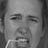

In [0]:
# get image from test folder (images arquived in subfolders)
p = PATH_test/'Disgust'
url = p.ls()[15]
img = open_image(url)
img

In [86]:
# get prediction

probs = learn.predict(img)[-1]
prediction = learn.data.classes[probs.argmax()]
prediction

'Disgust'

In [96]:
learn.save('fastai_model', return_path=True)

PosixPath('drive/My Drive/Colab_datasets/Emotion_detection/fer2013/models/fastai_model.pth')